In [1]:
import sys
sys.path.append('../')

import numpy as np
np.random.seed(314159)

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import parameter_tuning
import plot_boundary
import analysis_functions as af

from metric_functions import compute_accuracy, compute_auc_from_scores
from kernel_SVM_functions import rbf_kernel
from classifiers import QUBOSoftMarginClassifier, SoftMarginKernelClassifier

In [2]:
train_size = 0.4
filename = 'virginica-setosa'

run_qsvms = False
run_csvm = False

In [3]:
#Set up train and test data
data = pd.read_csv(f'../iris_data/{filename}.csv').to_numpy()

X = data[:, 1: -1]
t = data[:, -1]
#iris_setosa will be 1, iris-versicolor will be -1
t[t == 'Iris-virginica'] = 1
t[t == 'Iris-setosa'] = -1
t = t.astype('float')

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size = train_size, shuffle = True, stratify = t)
t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

## QSVMs calibration

In [4]:
B_values = [2, 3, 5, 10]
K_values = [2, 3, 4]
R_values = [0, 1, 3, 5]
gamma_values = [2 ** i for i in range(-3, 3)]
kernel_func = rbf_kernel
#This results in a matrix with shape (4, 2, 4, 7)

if run_qsvms:

    accuracy_results, auroc_results, times = parameter_tuning.tune_qsvm_parameters(X_train, t_train, B_values, K_values, R_values, gamma_values, kernel_func, num_models = 30)

    np.save(f'../results/QUBO-{filename}-accuracy', accuracy_results)
    np.save(f'../results/QUBO-{filename}-auroc', auroc_results)
    np.save(f'../results/QUBO-{filename}-time', times)

Progress: 100%|██████████| 288/288 [54:38<00:00, 11.38s/it]


## cSVM calibration

In [5]:
C_values = [2 ** i for i in range(0, 7)]
gamma_values = [2 **i for i in range(-3, 3)]
kernel_func = rbf_kernel

if run_csvm:

    accuracy_results, auroc_results, times = parameter_tuning.tune_csvm_parameters(X_train, t_train, C_values, gamma_values, kernel_func)

    np.save(f'../results/kSVM-{filename}-accuracy', accuracy_results)
    np.save(f'../results/kSVM-{filename}-auroc', auroc_results)
    np.save(f'../results/kSVM-{filename}-time', times)

Progress: 100%|██████████| 42/42 [00:12<00:00,  3.25it/s]


## Get data from files

In [6]:
qSVM_accuracy = np.load(f'../results/QUBO-{filename}-accuracy.npy')
qSVM_auroc = np.load(f'../results/QUBO-{filename}-auroc.npy')

cSVM_accuracy = np.load(f'../results/kSVM-{filename}-accuracy.npy')
cSVM_auroc = np.load(f'../results/kSVM-{filename}-auroc.npy')

In [7]:
qSVM_accuracy.shape, cSVM_accuracy.shape

((4, 3, 4, 6), (7, 6))

## Best calibration performance

In [8]:
print(f'cSVM best accuracy {np.max(cSVM_accuracy[:, 1: ])} \n cSVM best auroc {np.max(cSVM_auroc[:, 1: ])} \n')
print(f'qSVM best accuracy {np.max(qSVM_accuracy)} \n qSVM best auroc {np.max(qSVM_auroc)} \n')

cSVM best accuracy 1.0 
 cSVM best auroc 1.0 

qSVM best accuracy 1.0 
 qSVM best auroc 1.0 



## Best QSVMs models

In [9]:
#Finding the 20 QSVMs models which performed best in the calibration phase.

val_list = [B_values, K_values, R_values, gamma_values]
model_indices = af.find_best(qSVM_auroc, 20)
top_qsvms_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]

In [10]:
#50 of each of the top models are trained on the full training set and tested on the test set.
#The AUROC and accuracy is averaged as the final AUROC and Accuracy score for that dataset.

tp_acc_mean = []
tp_acc_std = []

tp_auc_mean = []
tp_auc_std = []

kernel_func = rbf_kernel
n = 50

for i, model_parameters in enumerate(top_qsvms_models):

    accuracy = []
    auroc = []

    for j in range(n):
        
        qsmc = QUBOSoftMarginClassifier(model_parameters[0], model_parameters[1], model_parameters[2], kernel_func, model_parameters[3])
        qsmc = qsmc.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
        scores = qsmc.decision_function(X_test)
        preds = qsmc.predict(X_test)
        
        accuracy.append(compute_accuracy(preds, t_test))
        auroc.append(compute_auc_from_scores(scores, t_test))

    tp_acc_mean.append(np.mean(accuracy))
    tp_acc_std.append(np.std(accuracy))

    tp_auc_mean.append(np.mean(auroc))
    tp_auc_std.append(np.std(auroc))

In [11]:
sort_index = np.unravel_index(np.argsort(-np.array(tp_auc_mean)), np.array(tp_auc_mean).shape)

top_qsvms_models = np.array(top_qsvms_models)[sort_index]

tp_acc_mean = np.array(tp_acc_mean)[sort_index]
tp_acc_std = np.array(tp_acc_std)[sort_index]

tp_auc_mean = np.array(tp_auc_mean)[sort_index]
tp_auc_std = np.array(tp_auc_std)[sort_index]

In [12]:
print(top_qsvms_models)

[[2.    2.    0.    0.125]
 [2.    2.    3.    4.   ]
 [2.    2.    3.    2.   ]
 [2.    2.    3.    1.   ]
 [2.    2.    3.    0.5  ]
 [2.    2.    3.    0.25 ]
 [2.    2.    3.    0.125]
 [2.    2.    1.    4.   ]
 [2.    2.    1.    2.   ]
 [2.    2.    1.    1.   ]
 [2.    2.    1.    0.5  ]
 [2.    2.    1.    0.25 ]
 [2.    2.    1.    0.125]
 [2.    2.    0.    4.   ]
 [2.    2.    0.    2.   ]
 [2.    2.    0.    1.   ]
 [2.    2.    0.    0.5  ]
 [2.    2.    0.    0.25 ]
 [2.    2.    5.    0.125]
 [2.    2.    5.    0.25 ]]


In [13]:
print(tp_auc_mean)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


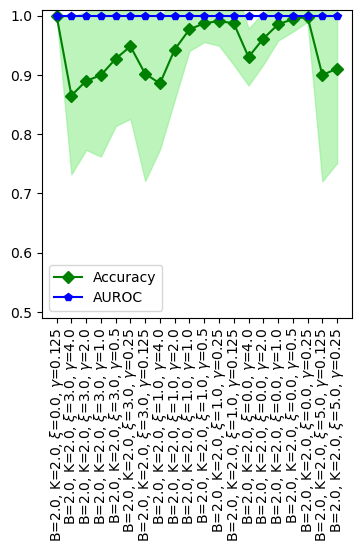

In [14]:
fig, ax = plt.subplots(figsize = (4, 4))

af.plot_top_models(top_qsvms_models, np.array([tp_acc_mean, tp_acc_std]), np.array([tp_auc_mean, tp_auc_std]), fig = fig, ax = ax)
plt.show()

## Best cSVM Models

In [15]:
#Finding the 50 cSVM models which performed best in the calibration phase.

val_list = [C_values, gamma_values]
model_indices = af.find_best(cSVM_auroc, 5)
top_csvm_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]

In [16]:
#Each of the top 5 csvm models are trained on the full training set and tested on the test set.
#The AUROC and accuracy are the final scores for that dataset.

final_auroc = []
final_accuracy = []

for c, g in top_csvm_models:

    clf = SoftMarginKernelClassifier(c, kernel_func, g)
    clf = clf.fit(X_train, t_train)

    preds = clf.predict(X_test)
    scores = clf.decision_function(X_test)

    final_auroc.append(compute_auc_from_scores(scores, t_test))
    final_accuracy.append(compute_accuracy(preds, t_test))
    

In [17]:
sort_index = np.argsort(-np.array(final_auroc))

top_csvm_models = np.array(top_csvm_models)[sort_index]
final_auroc = np.array(final_auroc)[sort_index]
final_accuracy = np.array(final_accuracy)[sort_index]

In [18]:
print(top_csvm_models, '\n', final_auroc)

[[1.    0.125]
 [1.    0.25 ]
 [1.    0.5  ]
 [1.    1.   ]
 [1.    2.   ]] 
 [1. 1. 1. 1. 1.]
